In [19]:
import numpy as np
import os
from itertools import repeat
import tifffile as ti

import cv2
from skimage.util import img_as_ubyte, img_as_uint
from scipy.ndimage import binary_fill_holes
from skimage import measure
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [15, 12]
from joblib import Parallel, delayed


def IoU(pred: np.ndarray, ground_truth: np.ndarray) -> float:
	"""
	Computes the Intersection over Union (IoU) score for binary segmentation.
	
	Parameters:
		pred (numpy.ndarray): The predicted mask.
		ground_truth (numpy.ndarray): The ground truth mask.
		
	Returns:
		float: The IoU score.
	"""
	if pred.shape != ground_truth.shape:
		raise ValueError('Inputs must have the same shape')

	# Convert both arrays to int in case they were bools
	pred = pred.astype(int)
	ground_truth = ground_truth.astype(int)

	# If there are no labeled pixels in the ground truth mask, just compute IoU score for the background
	if np.count_nonzero(ground_truth) == 0:
		pred = (1-pred)
		ground_truth = (1-ground_truth)
		num = np.sum(pred*ground_truth)
		denum = np.sum(pred + ground_truth - (pred*ground_truth))
		background_score = num/denum
		return background_score

	# Else, return the mean of the background and labeled pixels IoU scores
	else:
		# labeled pixels IoU score
		num = np.sum(pred*ground_truth)
		denum = np.sum(pred + ground_truth - (pred*ground_truth))
		worm_score = num/denum

		# background prediction IoU score
		pred = (1-pred)
		ground_truth = (1-ground_truth)
		num = np.sum(pred*ground_truth)
		denum = np.sum(pred + ground_truth - (pred*ground_truth))
		background_score = num/denum
		return (worm_score + background_score)/2
	
def f_beta_score(pred: np.ndarray, ground_truth: np.ndarray, beta_background=1., beta_foreground = 1.) -> float:
	"""
	Computes the Intersection over Union (IoU) score for binary segmentation.
	
	Parameters:
		pred (numpy.ndarray): The predicted mask.
		ground_truth (numpy.ndarray): The ground truth mask.
		
	Returns:
		float: The IoU score.
	"""
	if pred.shape != ground_truth.shape:
		raise ValueError('Inputs must have the same shape')

	# Convert both arrays to int in case they were bools
	pred = pred.astype(int)
	ground_truth = ground_truth.astype(int)

	# If there are no labeled pixels in the ground truth mask, just compute IoU score for the background
	if np.count_nonzero(ground_truth) == 0:
		pred = (1-pred)
		ground_truth = (1-ground_truth)
		
		true_positives = np.sum(pred*ground_truth)
		true_negatives = np.sum((1-pred)*(1-ground_truth))
		false_positives = np.sum(pred*(1-ground_truth))
		false_negatives = np.sum((1-pred)*ground_truth)
		
		precision= true_positives/(true_positives+false_positives)
		recall = true_positives/(true_positives + false_negatives)
		
		num = ((1+beta_background**2)*precision*recall)
		denum = ((beta_background**2)*precision + recall)
		f_beta_background = num/denum
		return f_beta_background

	# Else, return the mean of the background and labeled pixels IoU scores
	else:
		if np.count_nonzero(pred) != 0:
			# labeled pixels IoU score
			true_positives = np.sum(pred*ground_truth)
			true_negatives = np.sum((1-pred)*(1-ground_truth))
			false_positives = np.sum(pred*(1-ground_truth))
			false_negatives = np.sum((1-pred)*ground_truth)
			
			precision= true_positives/(true_positives+false_positives)
			recall = true_positives/(true_positives + false_negatives)
			
			num = ((1+beta_foreground**2)*precision*recall)
			denum = ((beta_foreground**2)*precision + recall)
		
			print(f'num : {num}, denum : {denum}')
			if true_positives == 0:
				f_beta_foreground = 0
			else:
				f_beta_foreground = num/denum
		else:
			f_beta_foreground = 0

		# background prediction IoU score
		pred = (1-pred)
		ground_truth = (1-ground_truth)
		
		true_positives = np.sum(pred*ground_truth)
		true_negatives = np.sum((1-pred)*(1-ground_truth))
		false_positives = np.sum(pred*(1-ground_truth))
		false_negatives = np.sum((1-pred)*ground_truth)
		
		precision= true_positives/(true_positives+false_positives)
		recall = true_positives/(true_positives + false_negatives)
		
		num = ((1+beta_background**2)*precision*recall)
		denum = ((beta_background**2)*precision + recall)
		f_beta_background = num/denum
		return (f_beta_background + f_beta_foreground)/2
	
def evaluate_segmentation_canny_plane(mCh_image: str, ground_truth_mask : str, augment_contrast : bool, sigma_canny : float, plot = False) -> float:
	"""
	Segment the nuclei out of a z-stack image using the Canny edge detection algorithm.
	
	Args:
		mCh_image (str): Path to the z-stack image.
		output_dir (str): Path to the directory where the segmented nuclei masks will be saved.
	
	Returns:
		None
	"""
	
	# Load the 3D volume image (stack) of nuclei from the given input image
	nuclei_plane = ti.imread(mCh_image)

	ground_truth = img_as_ubyte(ti.imread(ground_truth_mask))
	# Normalize the image intensities to [0,1]
	normalized_nuclei_image = np.divide(nuclei_plane, np.max(nuclei_plane))
	
	if augment_contrast == True:
		clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(8,8))
		nuclei_image = clahe.apply(img_as_uint(normalized_nuclei_image))
	# Convert the normalized image to 16-bit unsigned integer format
	else:
		nuclei_image = img_as_uint(normalized_nuclei_image)

	# Apply Gaussian blur on the image
	blurred_nuclei_image = cv2.GaussianBlur(nuclei_image, (0,0), sigma_canny)
	# Detect edges using Canny edge detection
	nuclei_edges = cv2.Canny(img_as_ubyte(blurred_nuclei_image), 0.1*256, 0.2*256) 

	# Define a cross-shaped structuring element for morphological operations
	cross_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
	# Perform morphological closing to fill gaps in the edges
	nuclei_edges = cv2.morphologyEx(nuclei_edges, cv2.MORPH_CLOSE, cross_kernel)

	# Because images were just translated to eliminate the shift, the small black border creates an edge we don't want, we thus have to remove it
	nuclei_edges[0:7, :] = 0
 
	# Fill the edges
	nuclei_mask = img_as_ubyte(binary_fill_holes(nuclei_edges))
	
	# Smooth the mask using median filtering
	nuclei_mask = cv2.medianBlur(nuclei_mask, 3)
	
	# Erode the binary mask a little bit
	nuclei_mask = cv2.morphologyEx(nuclei_mask, cv2.MORPH_ERODE, cross_kernel)

	# Label the connected components in the binary mask and calculate their properties
	labels = measure.label(nuclei_mask)
	props = measure.regionprops(labels, np.zeros_like(labels))

	# Keep only the labels (nuclei) that satisfy certain criteria, such as minimum area
	labels_to_keep = []
	for idx in range(0, labels.max()):
		label_i = props[idx].label
		# eccentricity = (props[idx]['eccentricity'])
		# solidity = (props[idx]['solidity'])
		area = (props[idx]['area'])
		# if solidity > 0.93 and eccentricity < 0.75 and area > 30:
		if area > 30:
			labels_to_keep.append(label_i)

	# Create a new binary mask containing only the nuclei with the selected labels
	good_nuclei_mask = np.isin(labels, labels_to_keep)
 
	if plot == True:
		plt.imshow(normalized_nuclei_image)
		plt.show()
		plt.imshow(good_nuclei_mask)
		plt.show()
		plt.imshow(ground_truth)
		plt.show()
	metric = f_beta_score(good_nuclei_mask, ground_truth, beta_background=2, beta_foreground=0.5)
	return metric

1e-06
num : 8.711410621051034e-05, denum : 1.0000174228212422
num : 0.46384005571952475, denum : 0.98659911168752
num : 0.037221054059553685, denum : 1.0074442108119108
num : 0.12336953029621539, denum : 0.9999357450363041
num : 0.008738256202927872, denum : 0.9485544929092699
num : 0.012049609122435783, denum : 1.002409921824487
num : 0.016388223620970397, denum : 0.9848550822586403
num : 0.002320765238340879, denum : 1.0004641530476681
num : 0.00010749561338271018, denum : 1.0000214991226766
num : 0.005586325639530738, denum : 1.001117265127906
num : 0.27239893124236364, denum : 1.0233542340794048
num : 0.30774815784309123, denum : 1.0113305387795224
num : 0.48834319624702427, denum : 1.0056153873363223
num : 0.09064070801441935, denum : 0.9498574195443095
num : 0.1290750893337902, denum : 1.025815017866758
num : 0.12365871605696865, denum : 1.0242053608603412
num : 0.018682621211266015, denum : 1.0037365242422531
num : 0.4153230376147451, denum : 1.0497563438179327
num : 0.208058145

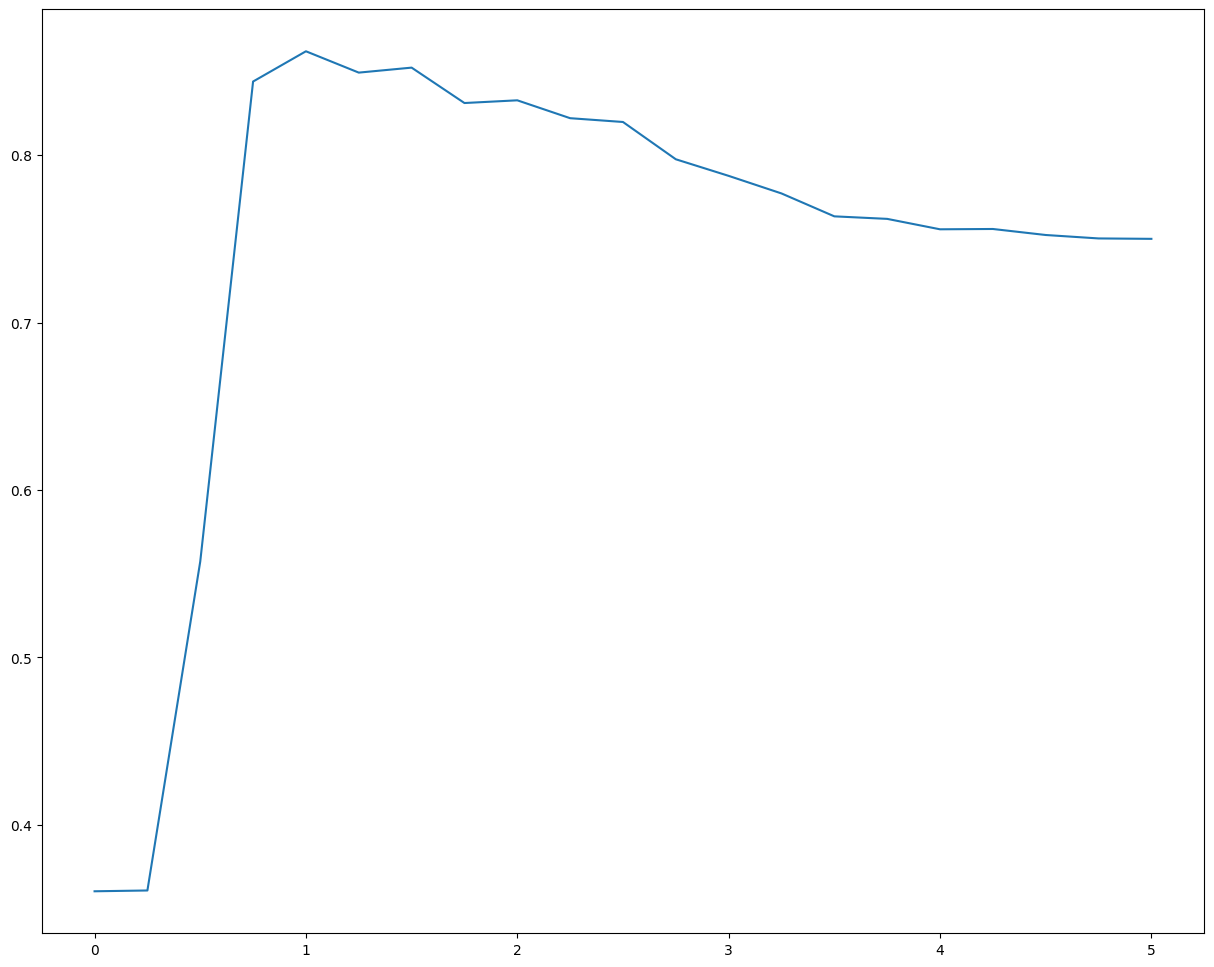

In [8]:
images_dir = "/mnt/external.data/TowbinLab/spsalmon/nuclei_segmentation_stardist_training/database_50/ch2_WBT281_frames/"
ground_truth_dir = "/mnt/external.data/TowbinLab/spsalmon/nuclei_segmentation_stardist_training/database_50/annotations/"

images = sorted([os.path.join(images_dir, x) for x in os.listdir(images_dir)])
ground_truths = sorted([os.path.join(ground_truth_dir, x) for x in os.listdir(ground_truth_dir)])
idx = 47
indexes = list(range(len(ground_truths)))
# indexes = [idx]

list_sigma_canny = np.linspace(0.000001, 5, 21)

without_contrast = []
with_contrast = []
for sigma_canny in list_sigma_canny:
    print(sigma_canny)
    scores = []
    scores = Parallel(n_jobs = 8, prefer="threads")(delayed(evaluate_segmentation_canny_plane)(images[i], ground_truths[i], False, sigma_canny) for i in indexes)
    mean_score = np.mean(np.array(scores))
    without_contrast.append(mean_score)
print(without_contrast)

plt.plot(list_sigma_canny, without_contrast)
plt.show()

In [9]:
# for sigma_canny in list_sigma_canny:
#     print(sigma_canny)
#     scores = []
#     scores = Parallel(n_jobs = 4, prefer="threads")(delayed(evaluate_segmentation_canny_plane)(images[i], ground_truths[i], True, sigma_canny) for i in indexes)
#     mean_score = np.mean(np.array(scores))
#     with_contrast.append(mean_score)
# print(with_contrast)

# plt.plot(list_sigma_canny, with_contrast)
# plt.show()

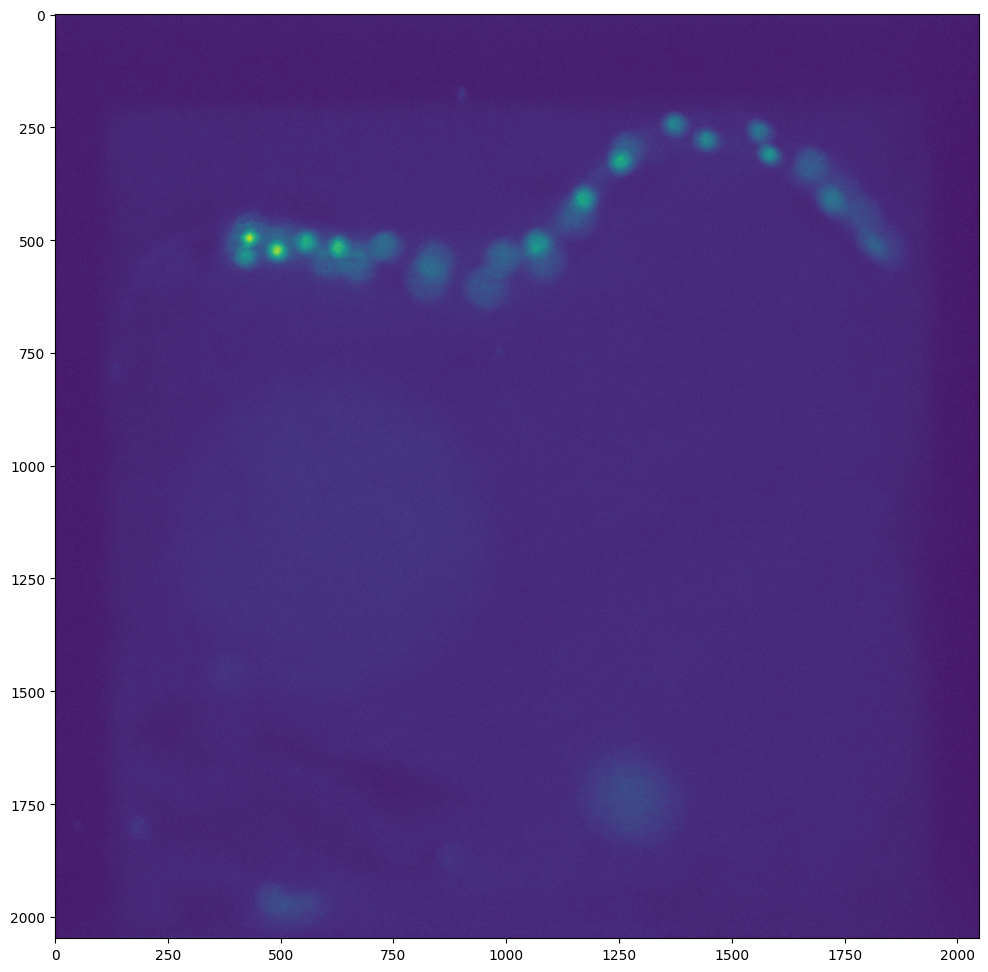

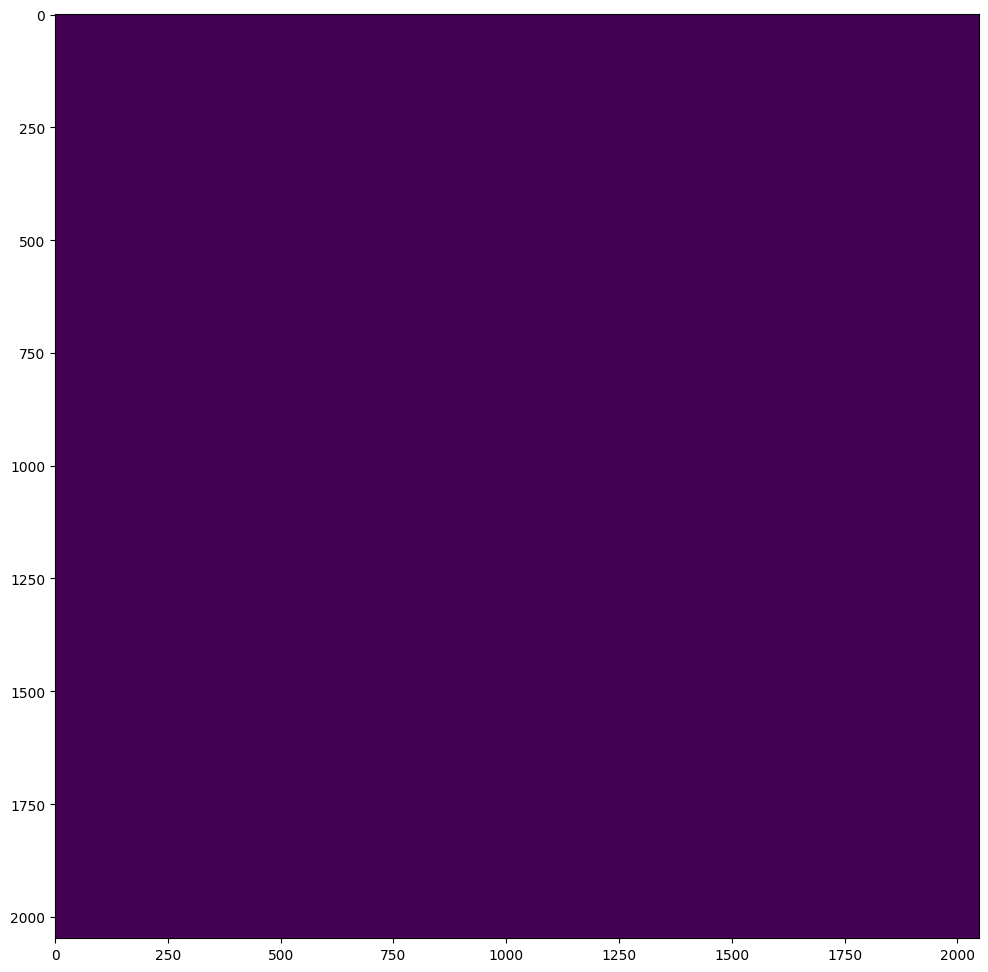

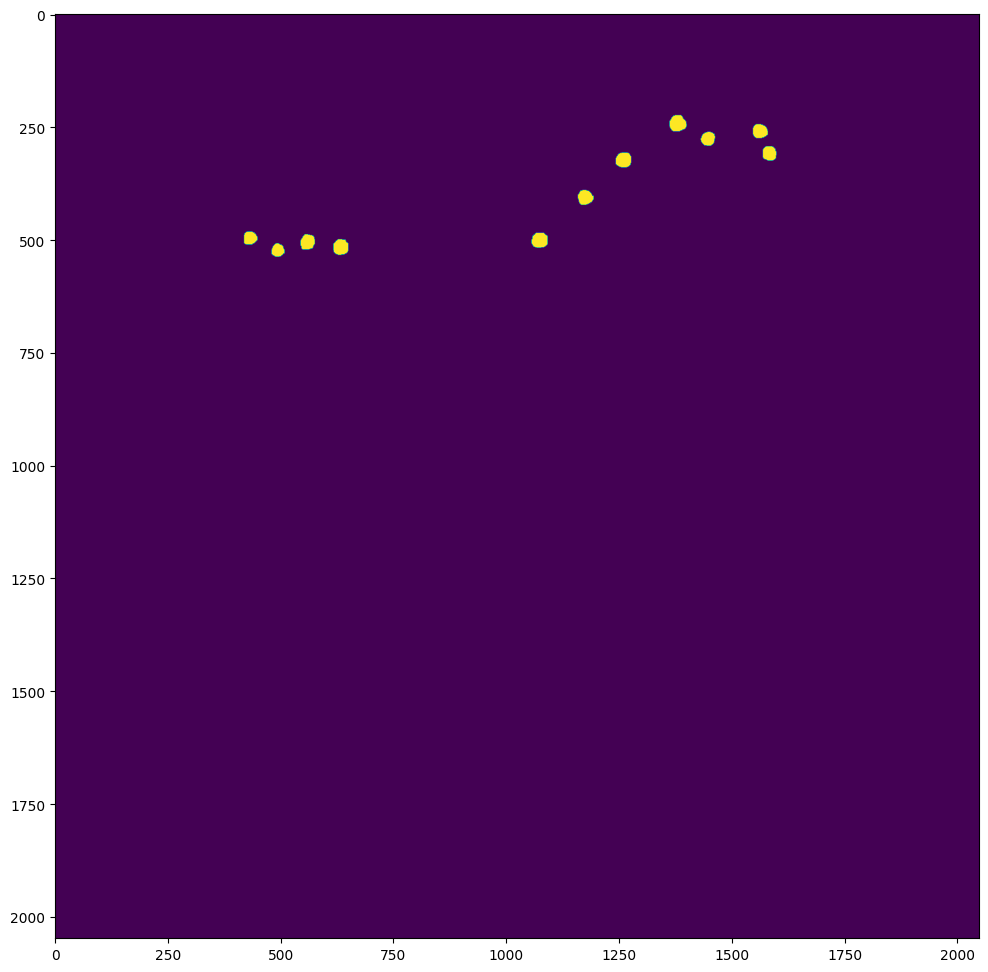

0.49976854461619014

In [27]:
idx = 46
evaluate_segmentation_canny_plane(images[idx], ground_truths[idx], False, 1.5, plot=True)